# LISA Example

Running the PSD estimator on LISA data from https://zenodo.org/records/15698080
(or /fred/oz303/avajpeyi/data/lisa_noise_4a/*.h5 if you have access to that)


In [9]:
! if [-f lisa_data.h5 ]; then wget https://zenodo.org/records/15698080/files/tdi.h5?download=1 -O lisa_data.h5 fi

/bin/bash: -c: line 1: syntax error: unexpected end of file


In [3]:
# autoreload 
%load_ext autoreload
%autoreload 2

In [6]:
import numpy as np

orig_h5 = 'tdi.h5'
# print all attributes of the h5 file
import h5py
with h5py.File(orig_h5, 'r') as f:
    for key in f.keys():
        print(key)
    data = np.array([f['X2'], f['Y2'], f['Z2']]).T
    time = np.array(f['t']).reshape(-1, 1)
    print(data.shape, time.shape)
    # truncate to 2**19 samples
    data = data[:2**19]
    time = time[:2**19]
    n = len(data[0])
    dt = time[1] - time[0]
    fs = 1 / dt
    


X2
Y2
Z2
t
(15778801, 3) (15778801, 1)


In [3]:
2 ** 19

524288

X2 (3, 40958) (40958,)
Y2 (3, 40958) (40958,)
Z2 (3, 40958) (40958,)
t (3, 40958) (40958,)


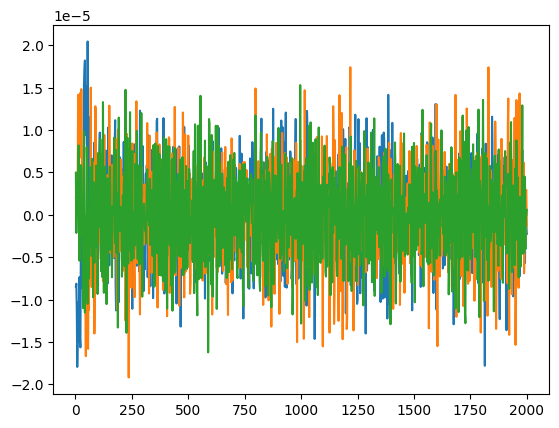

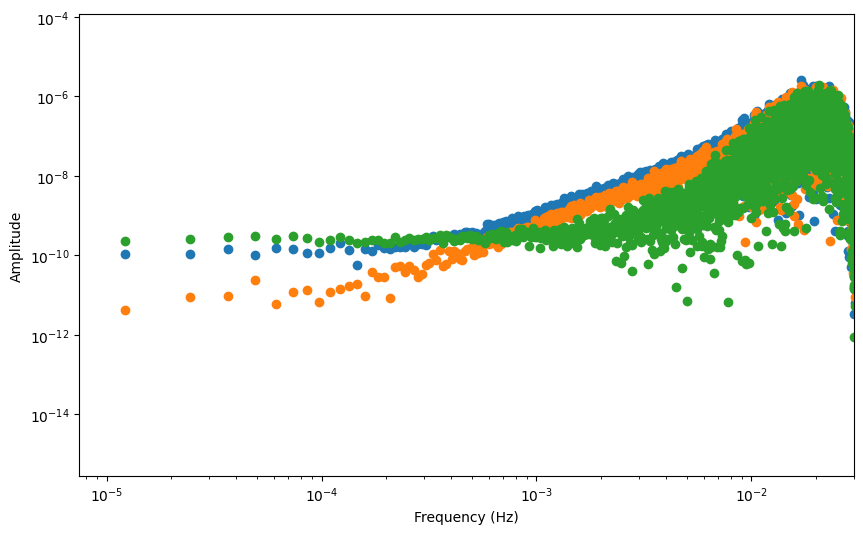

In [1]:
import h5py
import numpy as np
import matplotlib.pyplot as plt

file = h5py.File('truncated_lisa_data.h5', 'r')
for key in file.keys():
    data = np.array([file['X2'], file['Y2'], file['Z2']])
    time = np.array(file['t'])

    # # remove 1st and last elements to avoid issues with FFT
    data = data[:, 1:-1]
    time = time[1:-1]
    print(key, data.shape, time.shape)

n = len(data[0])
dt = time[1] - time[0]
fs = 1 / dt


plt.plot(time[0:1000], data.T[0:1000])
plt.show()

# Plotting the periodogram of the data
freq = np.fft.fftfreq(n, dt)
plt.figure(figsize=(10, 6))
for i in range(3):
    plt.scatter(freq[1:-1], np.abs(np.fft.fft(data[i])**2)[1:-1], label=f'Component {i+1}')
plt.xscale('log')
plt.yscale('log')
plt.xlim(right=0.3e-1)
plt.xlabel('Frequency (Hz)')
plt.ylabel('Amplitude');


In [9]:
from sgvb_psd.psd_estimator import PSDEstimator
import time


N_theta = 500
start_time = time.time()
optim = PSDEstimator(
    x=data,
    N_theta=N_theta,
    nchunks=8,
    fs=fs,
    ntrain_map=10000,
    n_elbo_maximisation_steps=1000,
    fmin_for_analysis=2*10**-4,
    fmax_for_analysis=5*10**-3,
    degree_fluctuate=600,
    seed=0,
)

optim.run(lr=0.005)  # remove lr to run-hyperoptimisation (takes a long time)
end_time = time.time()
estimation_time = end_time - start_time
print(f'The estimation time is {estimation_time:.2f}s')

optim.plot_coherence(labels='XYZ')
plt.savefig("lisa_coherence.png")
plt.close()

optim.plot(xlims=[1e-5, 1e-1], labels='XYZ')
plt.savefig("lisa_psd.png")
plt.close()

optim.plot_vi_losses()
plt.savefig("lisa_vi_losses.png")
plt.close()




17:02:48|SGVB-PSD|DEBUG| Seed set to 0
17:02:48|SGVB-PSD|INFO| Dividing data (524288, 3) into (8, 65536, 3) chunks
17:02:48|SGVB-PSD|INFO| Reducing the number of frequencies to be analyzed from 32768 to 0.005...
17:02:48|SGVB-PSD|INFO| Final PSD will be of shape: 629 x 3 x 3
17:02:48|SGVB-PSD|WARNING| Input data not standardised!
17:02:48|SGVB-PSD|INFO| Loaded AnalysisData(x(t)=(524288, 3), y(f)=(8, 629, 3), Xmat_delta=(629, 502), Xmat_theta=(629, 502), Z=(8, 629, 3, 3))
17:02:48|SGVB-PSD|DEBUG| Initialized model with [<tf.Variable 'ga_delta:0' shape=(1, 3, 502) dtype=float32, numpy=
array([[[0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.]]], dtype=float32)>, <tf.Variable 'lla_delta:0' shape=(1, 3, 500) dtype=float32, numpy=
array([[[ 0.,  0.,  0., ..., -1., -1., -1.],
        [ 0.,  0.,  0., ..., -1., -1., -1.],
        [ 0.,  0.,  0., ..., -1., -1., -1.]]], dtype=float32)>, <tf.Variable 'ga_theta_re:0' shape=(1, 3, 502) dtype

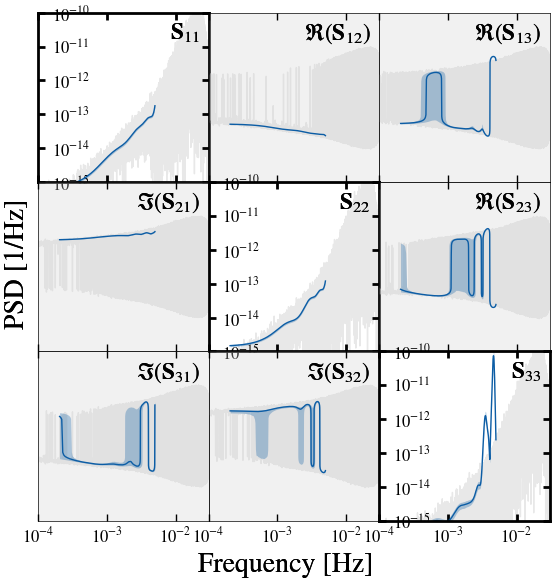

In [10]:

axes = optim.plot(xlims=[1e-5, 1e-1], labels='XYZ', sylmog_thresh=1e-20)
for i in range(3):
    for j in range(3):
        if i == j:
            axes[i,j].set_xscale('log')
            axes[i,j].set_yscale('log')
            axes[i,j].set_xlim(1e-4, 0.3e-1)
            axes[i,j].set_ylim(1e-15, 1e-10)
        else:
            axes[i,j].set_ylim(-1e-3, 1e-3)
            axes[i,j].set_yticks([])



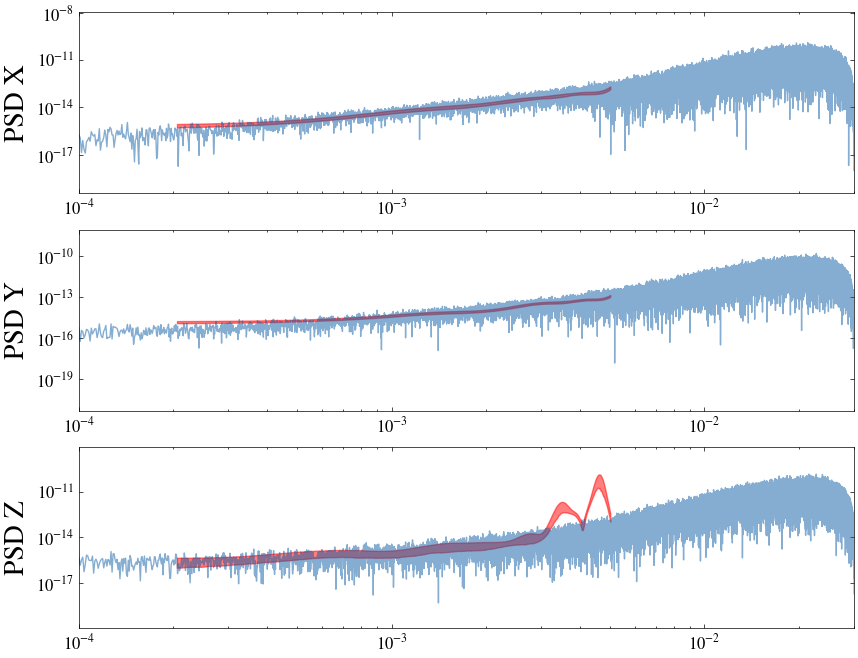

In [15]:
import matplotlib.pyplot as plt
fig, axes = plt.subplots(3, 1, figsize=(10, 8))

ci_low, ci_median, ci_upper = optim.uniform_ci # shape: (3, 2449, 3, 3)

channels = 'XYZ'
for i in range(3):
    axes[i].loglog(optim.pdgrm_freq, optim.pdgrm[...,i,i], label='Data', alpha=0.5)
    axes[i].fill_between(optim.freq, ci_low[...,i,i], ci_upper[...,i,i], color='red', alpha=0.5, label='95% CI')
    axes[i].set_xlim(1e-4, 0.3e-1)
    axes[i].set_ylabel(f'PSD {channels[i]}', fontsize=20)

In [17]:
ci_low[...,0, 0].shape

(2449,)